# Project: Weed Segmentation Using Neural Networks

### Objectives

This project aims to leverage neural networks to map weed presence in satellite images of crop fields and extract valuable agronomic statistics, such as:

- **Weed infestation levels**  
- **Terrain distribution**  
- **Estimated herbicide requirements**  
- **Diesel consumption**  
- **Total recovery cost of the field**  

The workflow begins with georeferenced sample points extracted from a `.tif` image. RGB values are obtained from these points and used to train a neural network capable of classifying pixels in the full image.

The main steps of this project are:

- Visualize the original image with annotated sample points  
- Analyze the class distribution in the dataset  
- Preprocess and split the dataset appropriately  
- Normalize the RGB samples  
- Design and train a neural network  
- Evaluate and validate the model  
- Predict weed presence on the entire image  
- Extract meaningful field statistics from the classified image  

---

### Author

[Pedro Henrique Amorim de Azevedo](https://www.linkedin.com/in/pedro-henrique-amorim-de-azevedo/)


In [ ]:
!pip install -q numpy geopandas pandas rasterio tqdm IPython matplotlib seaborn tensorflow scikit-learn

In [7]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

import rasterio
from rasterio.plot import show

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.preprocessing import OneHotEncoder

import tensorflow
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


%matplotlib inline

### Loading dataset

For organization purposes and to avoid having to deal with multiple dataframe variables, I will organize them into a dictionary called `gdfs` for GeoDataFrames.

In [8]:
# Global variables
dataset_folder = 'datasets'

paths = {
    'image': os.path.join(dataset_folder, 'AOI_img.tif'),
    'soil': os.path.join(dataset_folder, 'Solo.shp'),
    'vegetation': os.path.join(dataset_folder, 'Veg.shp'), 
    'weeds': os.path.join(dataset_folder, 'Invasoras.shp'),
}

gdfs = {
    'soil': gpd.read_file(paths['soil']),
    'vegetation': gpd.read_file(paths['vegetation']),
    'weeds': gpd.read_file(paths['weeds'])
}

class_names = {0: 'Soil', 1: 'Vegetation', 2: 'Weeds'}
class_colors = {0: 'sienna', 1: 'mediumseagreen', 2: 'khaki'}

model_path = os.path.join('models', 'classificador_checkpoint.keras')

### Plotting the study image

Let's plot the image of the study area and plot the sample points

* Soil
* Vegetation
* Weeds

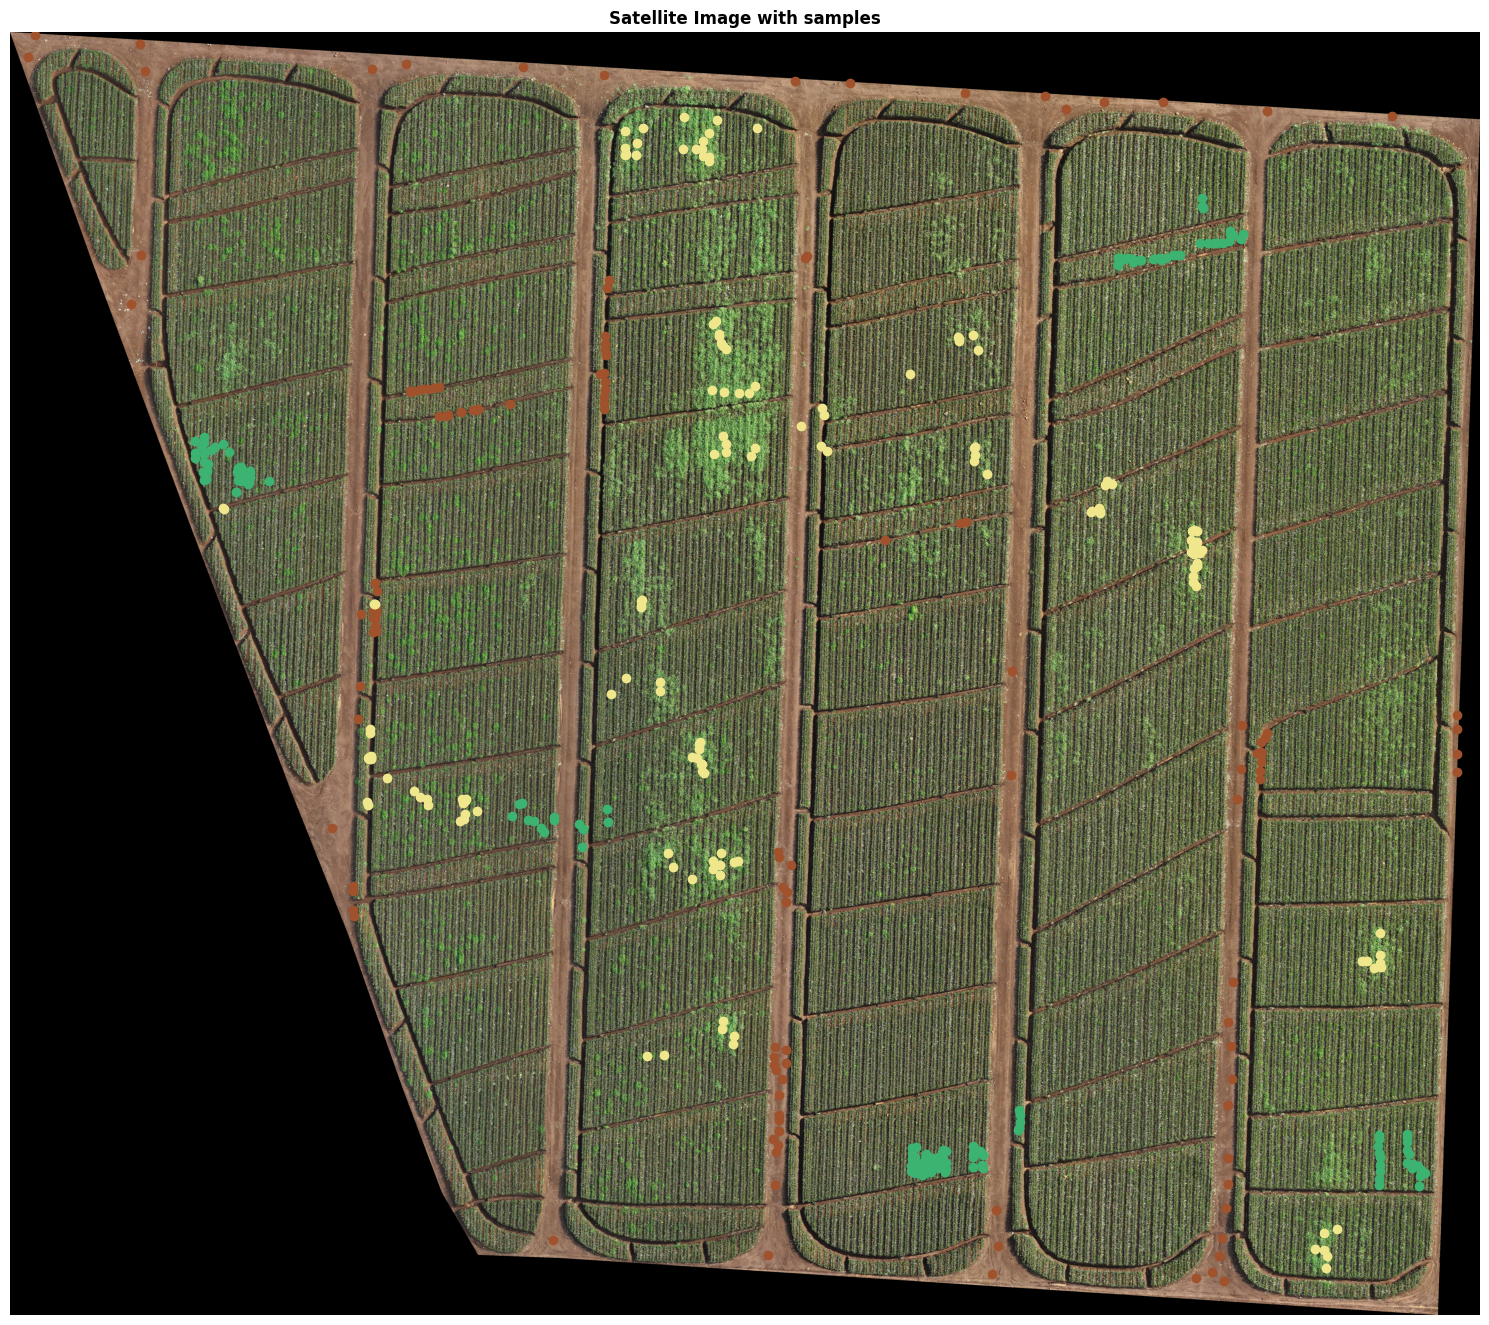

In [9]:
fig, ax = plt.subplots(figsize=(15, 15))
with rasterio.open(paths['image']) as src:
    # Adjust CRS of shapefiles
    for name, gdf in gdfs.items():
        gdfs[name] = gdf.to_crs(src.crs.to_dict()) # Convert to coordinates reference system

    # Show background image
    show(src, ax=ax, title='Satellite Image with samples')

    # Plot the sample points of each geodataframe
    gdfs['soil'].plot(ax=ax, color='sienna', label='Soil')
    gdfs['vegetation'].plot(ax=ax, color='mediumseagreen', label='Vegetation') 
    gdfs['weeds'].plot(ax=ax, color='khaki', label='Ervas Daninhas')

    plt.axis('off')
    plt.tight_layout()
    plt.show();

### Preparing data for training

To create a model that generalizes colors into coordinates for different classes (soil, vegetation, and weeds), we first need to:

1. Assign a unique `class_id` to each sample type, making it easier to identify later
2. Unify the geodataframes of all samples into a single dataset
3. Extract the precise geographic coordinates of each sample
4. Open the reference image and capture the RGB values ​​of the pixels corresponding to the coordinates
5. Organize the data into features (RGB values) and targets (classes)
5. Apply `train_test_split` from the Scikit-Learn library to separate the training and testing sets

This process will allow us to train a classifier that learns to associate color patterns with different types of land cover, enabling the automatic identification of areas of interest in aerial or satellite images.

In [10]:
# Adds especific ids to each class
gdfs['soil']['class_id'] = 0
gdfs['vegetation']['class_id'] = 1
gdfs['weeds']['class_id'] = 2
        
# Combine all geodataframes
combined_gdf = pd.concat([
    gdfs['soil'], 
    gdfs['vegetation'], 
    gdfs['weeds'] 
], axis=0)
        
# Extract samples coordinates
coords = [(x, y) for x, y in zip(combined_gdf.geometry.x, combined_gdf.geometry.y)]

# Extracts RGB values of each sample
with rasterio.open(paths['image']) as src:
    pixel_values = np.array([pixel_value for pixel_value in src.sample(coords)])
        

# Splits features from labels
X = pixel_values[:, 0:3]  # Just RGB
X = X / 255.0 # normalize the inputs
Y = combined_gdf['class_id'].values.reshape(-1, 1)
        
encoder = OneHotEncoder()
Y_encoded = encoder.fit_transform(Y).toarray()
        
X_train, X_test, y_train, y_test = train_test_split(X, Y_encoded, test_size=0.2, random_state=42)

### Class Distribution

Let's see if we have a balanced amount of pixel samples for training our model.

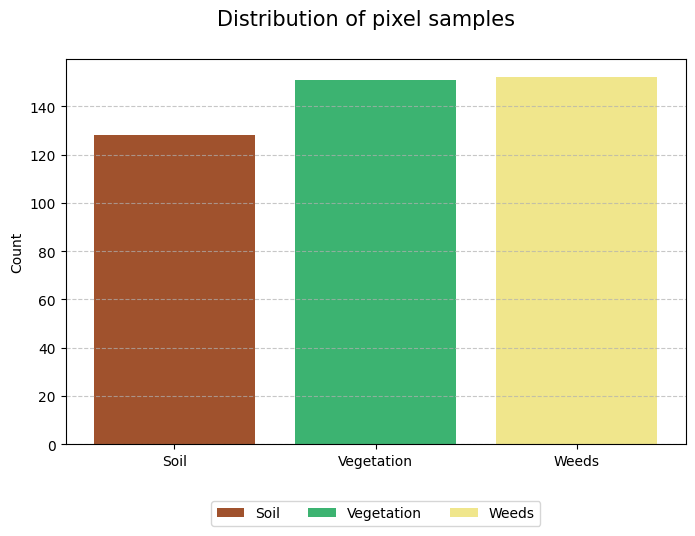

In [11]:
counts = pd.Series(combined_gdf['class_id']).value_counts().sort_index()
counts.index = counts.index.map(class_names.get)

plt.figure(figsize=(8, 5))
plt.bar(counts.index, counts, label=counts.index, color=class_colors.values())
plt.ylabel('Count')
plt.suptitle('Distribution of pixel samples', fontsize=15)
plt.xticks()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.18),
          ncol=3, fancybox=True)
plt.show();

### Creating the network

A sequential model with some Dense layers is enough to classify the pixels RGB channels properly.

In [12]:
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
EPOCHS = 100

model = Sequential([
    Dense(512, activation='elu', kernel_initializer='he_normal', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dense(256, activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(128, activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(64, activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(32, activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(len(class_names), activation='softmax')
])

optimizer = AdamW(learning_rate=LEARNING_RATE, weight_decay=1e-4)

model.compile(
	loss='categorical_crossentropy',
	optimizer=optimizer,
  	metrics=['accuracy']
)

# model.summary()

/home/pedro/anaconda3/envs/intellisis/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
callbacks = [
    ModelCheckpoint(
        model_path, monitor="val_accuracy", save_best_only=True, mode="max"
    ),
    ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1
    ),
]

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,  # Avoid data leakage
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=callbacks,
)

Epoch 1/100


I0000 00:00:1744657543.170066  194148 service.cc:152] XLA service 0x730e04008560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744657543.170085  194148 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-04-14 16:05:43.266349: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744657543.685385  194148 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/9 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.5625 - loss: 1.0197

I0000 00:00:1744657545.575341  194148 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 440ms/step - accuracy: 0.7134 - loss: 0.6672 - val_accuracy: 0.3333 - val_loss: 2.2565 - learning_rate: 0.0010
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9318 - loss: 0.2080 - val_accuracy: 0.3333 - val_loss: 2.3785 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9152 - loss: 0.2348 - val_accuracy: 0.3623 - val_loss: 2.5772 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9304 - loss: 0.2065 - val_accuracy: 0.3768 - val_loss: 2.0913 - learning_rate: 0.0010
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9026 - loss: 0.2561 - val_accuracy: 0.3913 - val_loss: 2.4465 - learning_rate: 0.0010
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9181 - loss: 0.2401 - val_accuracy: 0.4493 - val_loss: 1.7705 - learning_rate: 0.0010
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9162 - loss: 0.2295 - val_accuracy: 0.4493 - va

## Model training history plot

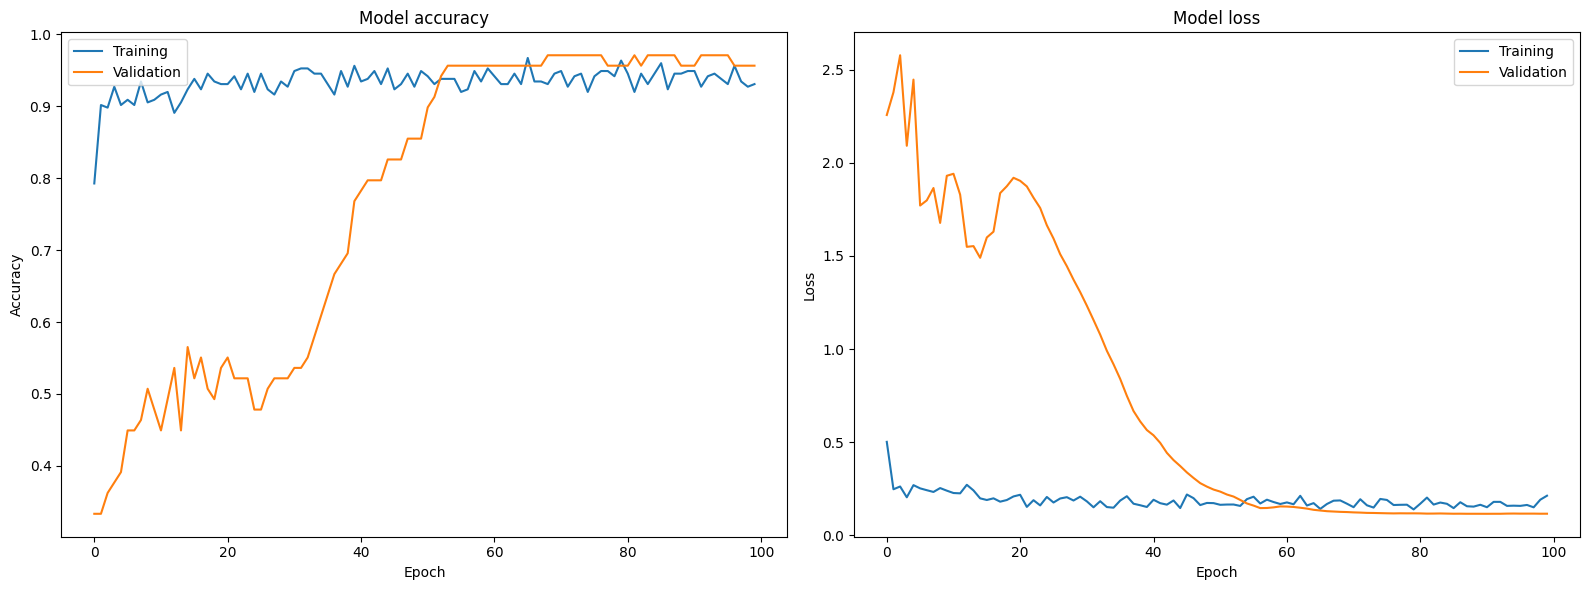

In [14]:
plt.figure(figsize=(16, 6))

# Accuracy history
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

# Loss history
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

To ensure that we use the best model saved by `ModelCheckpoint`, we will load it manually, since the `model` variable may not contain the best version arrived at during training.

In [15]:
best_model = load_model(model_path)

In [16]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

Test Loss: 0.1551
Test Accuracy: 0.9540


### Predictions and metrics on the test set

In [17]:
y_pred = best_model.predict(X_test)

# Predicted labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Ground truth labels
y_true_classes = np.argmax(y_test, axis=1)

get_class_names = np.vectorize(lambda c: class_names[c])

y_pred_classes = get_class_names(y_pred_classes)
y_true_classes = get_class_names(y_true_classes)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


## Cohen Kappa score

Cohen's Kappa is a robust metric for evaluating classification models. It's especialy useful when dealing with **imbalanced datasets**.

Unlike simple accuracy, which may be misleading when one class dominates the dataset, Cohen's Kappa takes into account the **agreement occurring by chance**. It compares the observed accuracy with the expected accuracy (random chance), providing a more reliable measure of a model's performance.

The Kappa coefficient ranges from -1 to 1:
- **1**: Perfect agreement
- **0**: Agreement equivalent to chance
- **< 0**: Worse than chance

This makes Cohen's Kappa a particularly valuable tool in our pixel-level image classification task, where class imbalance may be is common. 

In [18]:
kappa = cohen_kappa_score(y_true_classes, y_pred_classes)
print(f'Cohen Kappa Score: {kappa:.4f}')

Cohen Kappa Score: 0.9302


### Results

Let's plot the classification report and the confusion matrix

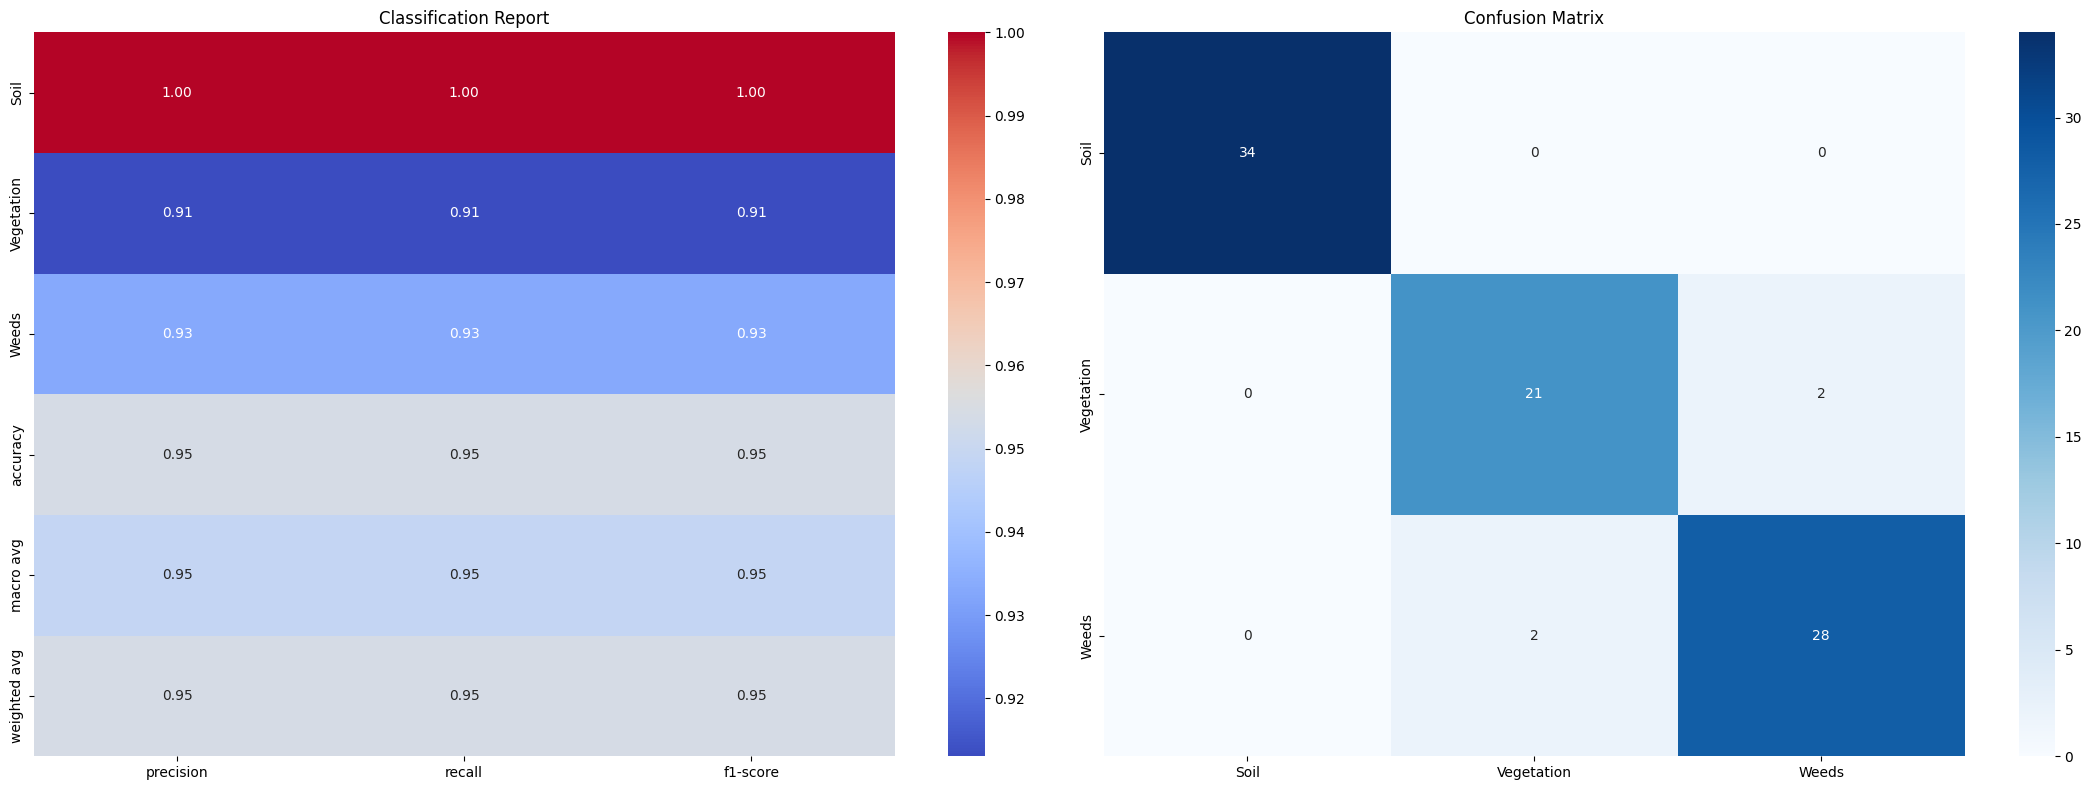

In [19]:
def plot_conf_matrix_report(y_pred, y_test):
	plt.figure(figsize=(22, 8))

	# Subplot 1 - Classification Report
	plt.subplot(1, 2, 1)
	plt.title('Classification Report')
	clf_report = classification_report(y_test, y_pred, output_dict=True)
	report_df = pd.DataFrame(clf_report).iloc[:-1, :].T  # Remove 'support'
	sns.heatmap(report_df, annot=True, cmap='coolwarm', fmt='.2f')

	# Subplot 2 - Confusion Matrix
	plt.subplot(1, 2, 2)
	plt.title('Confusion Matrix')
	conf_matrix = confusion_matrix(y_test, y_pred)
	sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
	
	plt.tight_layout()
	plt.show()


plot_conf_matrix_report(y_pred_classes, y_true_classes)

### Classifying full image

In [20]:
with rasterio.open(paths['image']) as src:
    # Read both image pixels and metadata
    img = src.read()
    meta = src.meta.copy()

    # (height × width × bands)
    img = img.transpose([1, 2, 0])
    original_shape = img.shape

    # Filter only valid pixels (mask == 255)
    valid_mask = img[:, :, 3] == 255
    valid_pixels = img[valid_mask][:, 0:3]  # RGB only (ignores alpha)
    valid_pixels = valid_pixels / 255.0

    # Usually we need to predict large images in batches
    print(f"Predicting {len(valid_pixels)} pixels")
    batch_size = 10000
    predictions = []
            
    for i in tqdm(range(0, len(valid_pixels), batch_size)):
        batch = valid_pixels[i:i + batch_size]
        pred = best_model.predict(batch, verbose=0)
        predictions.append(np.argmax(pred, axis=1))
            
    predictions = np.concatenate(predictions)
    

Predicting 40036037 pixels


100%|██████████| 4004/4004 [36:55<00:00,  1.81it/s]


### Creating a matrix of predicted pixels

Now we will create a matrix whose values ​​represent the class to which it belongs (soil, vegetation or weed). Note that we created a matrix with the same dimensions as the original image, but initialized with values ​​of -1. Then we assign the predicted classes to each valid pixel, that is whise alpha band is 255.

In [21]:
classified = np.full((original_shape[0], original_shape[1]), -1, dtype=np.int16)
classified[valid_mask] = predictions

# Save numpy matrix for later use
classified_path = os.path.join('outputs', 'classified_pixels')
np.save(classified_path, classified)

### Checkpoint
If you don't want to or don't have the computational capacity to predict the entire image, we can use a numpy array containing the predictions

In [22]:
#classified_path = os.path.join('outputs', 'classified_pixels.npy')
#classified = np.load(classified_path)

Loading Soil pixels...
Loading Vegetation pixels...
Loading Weeds pixels...


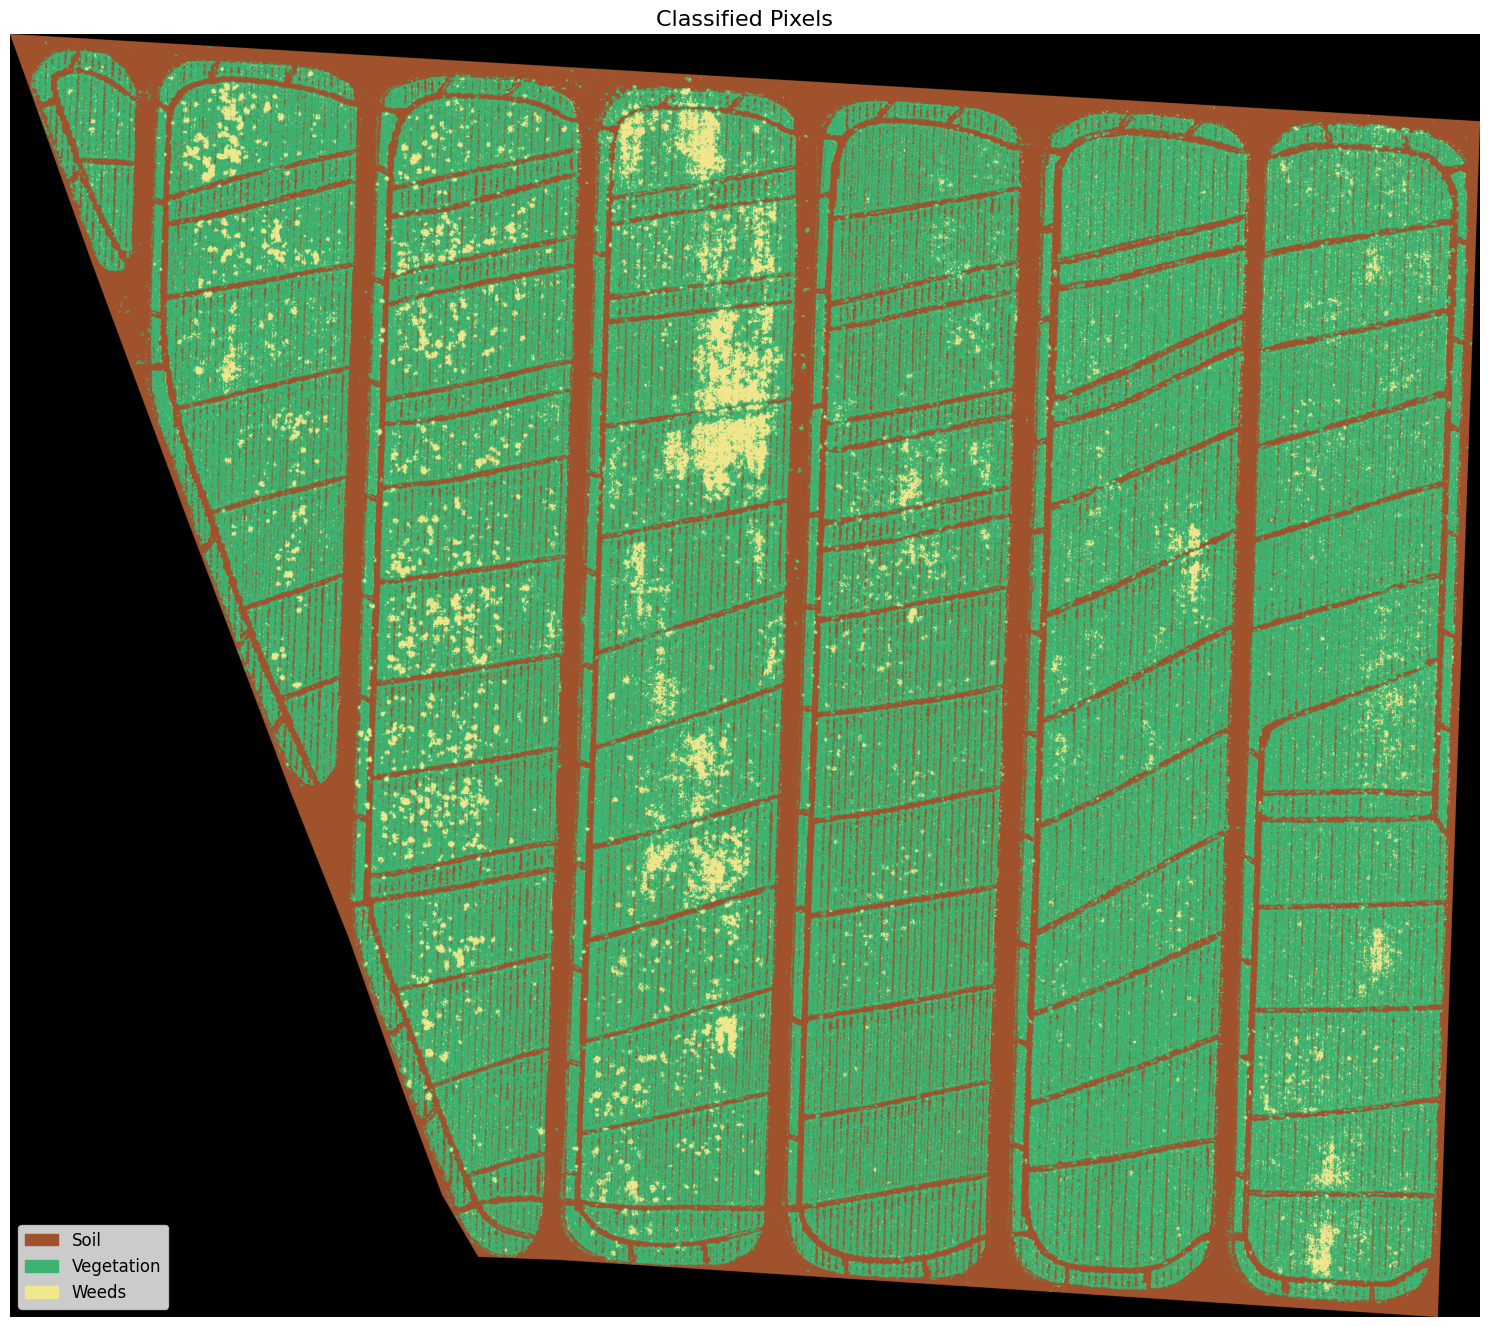

In [23]:
def get_rgb(color: str):
    return tuple(int(x * 255) for x in plt.cm.colors.to_rgba(color)[:3])


# Create a transparent image
colored = np.empty((*classified.shape, 3), dtype=np.uint8)

# Load each class of pixels in the image
for class_id, color in class_colors.items():
	print(f'Loading {class_names[class_id]} pixels...')
	mask = classified == class_id
	color_rgb = get_rgb(color)
	colored[mask] = color_rgb

plt.figure(figsize=(15, 15))
plt.imshow(colored)
plt.title('Classified Pixels', fontsize=16)

# Create legend
patches = []
for color in class_colors.values():
	color_rgb = get_rgb(color)
	color_rgb = np.array(color_rgb) / 255
	patches.append(plt.Rectangle((0, 0), 1, 1, color=color_rgb))

plt.legend(patches, class_names.values(), loc='lower left', fontsize=12)

plt.axis('off')
plt.tight_layout()
plt.show()

## Saving predicted image

In [24]:
# Update matadata
meta.update({
    'driver': 'GTiff',
    'count': 3,
    'dtype': 'uint8',
    'nodata': None,
    'compress': 'lzw'
})
        
# Save as GeoTIFF
save_path = os.path.join('outputs', 'mapa_classificado.tif')
with rasterio.open(save_path, 'w', **meta) as dst:
    rgb_image = colored.transpose((2, 0, 1))  # from (H, W, 3) to (3, H, W)
    dst.write(rgb_image)
    print('Image saved successfully')

Image saved successfully


# Crop Statistics

Now that we have a image of classified pixel, we can use the count per class to extract some insights

In [25]:
# Pixel count per class
unique, counts = np.unique(classified, return_counts=True)
class_counts = dict(zip(unique, counts))

# Delete the black pixel count
del class_counts[-1]

## Total area per class

As we can get the pixel area from the original image, let's calculate the area of each pixel class we have (Soil, Vegetation and Weed)

In [26]:
pixel_area_m2 = abs(src.transform[0] * src.transform[4])
pixel_area_ha = pixel_area_m2 / 10_000

area_por_classe_ha = {class_names[cls]: count * pixel_area_ha for cls, count in class_counts.items()}

In [27]:
area_por_classe_ha

{'Soil': np.float64(1.1249606306415676),
 'Vegetation': np.float64(2.556123462346412),
 'Weeds': np.float64(0.23734369674257463)}

### Gráfico de distribuição das áreas

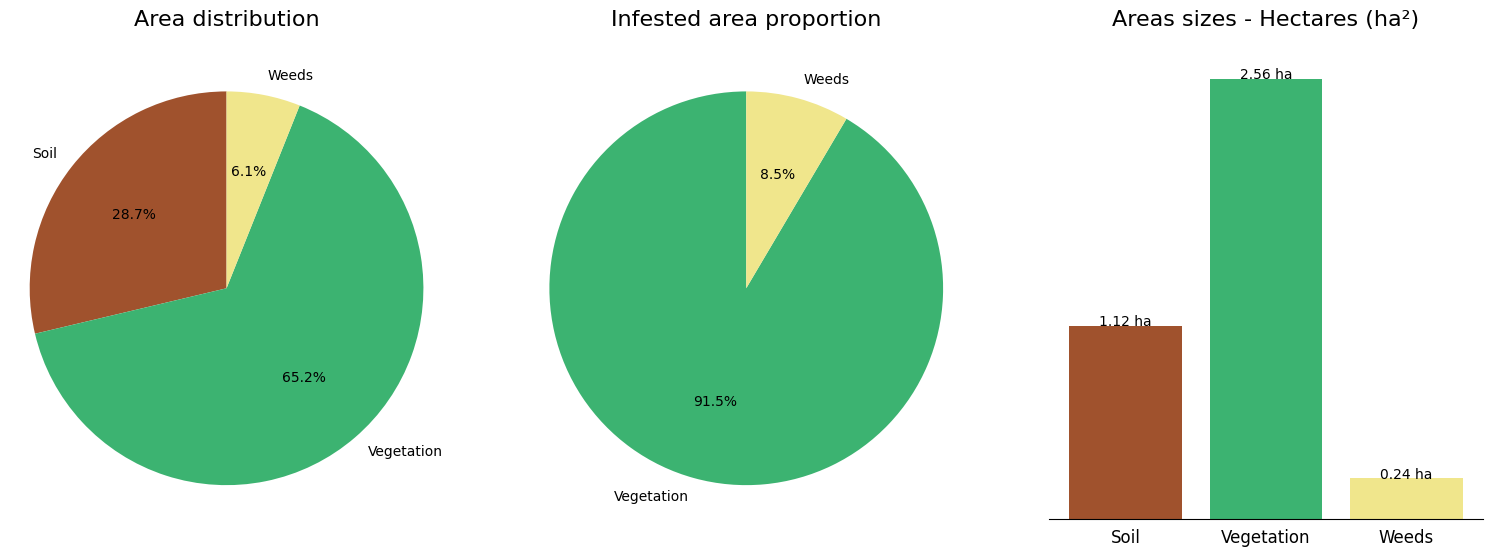

In [28]:
plt.figure(figsize=(19, 6))


# Area distribution
plt.subplot(1, 3, 1)
plt.pie(area_por_classe_ha.values(),
        labels=area_por_classe_ha.keys(),
        colors=class_colors.values(),
        autopct='%1.1f%%',
        startangle=90)
plt.title('Area distribution', y=1.05, fontsize=16)
plt.axis('equal')


# Infested area proportion
plt.subplot(1, 3, 2)
area_infestada_ha = area_por_classe_ha.copy()
del area_infestada_ha['Soil']

plt.pie(area_infestada_ha.values(), 
        labels=area_infestada_ha.keys(), 
    	colors=list(class_colors.values())[1:], 
  		autopct='%1.1f%%', startangle=90)
plt.title('Infested area proportion', y=1.05, fontsize=16)
plt.axis('equal')


# Area sizes
plt.subplot(1, 3, 3)
plt.bar(area_por_classe_ha.keys(), area_por_classe_ha.values(), color=class_colors.values())
plt.title('Areas sizes - Hectares (ha²)', y=1.05, fontsize=16)
for i, (label_, value) in enumerate(area_por_classe_ha.items()):
    plt.text(i, value, f"{value:.2f} ha", ha='center')
plt.xticks(fontsize=12)
plt.yticks([]) 
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.tick_params(left=False, bottom=False)


plt.show();

<img src="https://i.ytimg.com/vi/P2YPG8PO9JU/maxresdefault.jpg">

# Using drones for spraying

In [36]:
area_inf_ha = area_por_classe_ha['Weeds'] #+ area_por_classe_ha['Weed'] # example: 1.75 ha

# Inputs / hectare
herbicide_L_ha = 0.1        # Remember 100 mL = 0.1 L
water_L_ha = 200
energy_kWh_ha = 2.0         # Medium-sized drone

herbicide_total_L = area_inf_ha * herbicide_L_ha
water_total_L = area_inf_ha * water_L_ha
energy_total_kWh = area_inf_ha * energy_kWh_ha

print('Quantities:')
print(f'Herbicide: {herbicide_total_L:.2f} L')
print(f'Water: {water_total_L:.2f} L')
print(f'Energy: {energy_total_kWh:.2f} kWh')

Quantities:
Herbicide: 0.02 L
Water: 47.47 L
Energy: 0.47 kWh


In [37]:
# Estimated prices
herbicide_price_L = 600.00   # R$/L
water_price_1000L = 1.00        # R$/1000L
energy_price_kWh = 0.50          # R$/kWh

# Individual costs
herbicide_cost = herbicide_total_L * herbicide_price_L
water_cost = (water_total_L / 1000) * water_price_1000L
energy_cost = energy_total_kWh * energy_price_kWh

total_cost = herbicide_cost + water_cost + energy_cost

print('Total costs for current area:')
print(f'Herbicide: R$ {herbicide_cost:.2f}')
print(f'Water: R$ {water_cost:.2f}')
print(f'Energy: R$ {energy_cost:.2f}')
print(f'Total: R$ {total_cost:.2f}')

Total costs for current area:
Herbicide: R$ 14.24
Water: R$ 0.05
Energy: R$ 0.24
Total: R$ 14.53


NOTA: Nesses cálculos não levaremos em nota mão de obra e o custo de aquirição e manutençâo do drone, bem como o deslocamento até o campo.